In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../data/online_retail_cleaned_2009-2011.csv')
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.normalize()
df = df[df['CustomerID'].notnull()]
df['CustomerID'] = df['CustomerID'].astype(int)
df = df.drop([
    # 'IsCancelled', 
    # 'TotalPrice',
    ], axis=1).dropna(subset=['CustomerID'])
print(df.shape)
df.head(3)

(824364, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085,United Kingdom,False,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom,False,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom,False,81.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1062988
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   UnitPrice    824364 non-null  float64       
 6   CustomerID   824364 non-null  int64         
 7   Country      824364 non-null  object        
 8   IsCancelled  824364 non-null  bool          
 9   TotalPrice   824364 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 63.7+ MB


In [8]:
df = df[~df['Description'].isin(['Manual','Discount','This is a test product.'])]
df.shape

(823059, 10)

In [9]:
df_diario = df.groupby(['CustomerID','InvoiceDate','Country']).agg(
            Invoices=('InvoiceNo', lambda x: x[~x.str.startswith('C')].nunique()),
            Invoices_canceled=('InvoiceNo', lambda x: x[x.str.startswith('C')].nunique()),
            Unique_products_buy=('StockCode', lambda x: x[df.loc[x.index, 'Quantity'] > 0].nunique()),
            Unique_products_return=('StockCode', lambda x: x[df.loc[x.index, 'Quantity'] < 0].nunique()),
            Items_buy=('Quantity', lambda x: x[x > 0].sum()),
            Items_return=('Quantity', lambda x: x[x < 0].sum()),
            Items_net=('Quantity','sum'),
            Value_buy=('TotalPrice', lambda x: x[x > 0].sum()),
            Value_return=('TotalPrice', lambda x: x[x < 0].sum()),
            Total_value=('TotalPrice', 'sum'),
            ).reset_index()
df_diario

,CustomerID,InvoiceDate,Country,Invoices,Invoices_canceled,Unique_products_buy,Unique_products_return,Items_buy,Items_return,Items_net,Value_buy,Value_return,Total_value
0,12346,2010-01-26,United Kingdom,0,1,0,1,0,-1,-1,0.00,-103.5,-103.50
1,12346,2010-03-02,United Kingdom,1,0,5,0,5,0,5,27.05,0.0,27.05
2,12346,2010-06-28,United Kingdom,1,0,19,0,19,0,19,142.31,0.0,142.31
3,12346,2011-01-18,United Kingdom,1,1,1,1,74215,-74215,0,77183.60,-77183.6,0.00
4,12347,2010-10-31,Iceland,1,0,40,0,509,0,509,611.53,0.0,611.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38192,18287,2010-09-21,United Kingdom,2,0,21,0,508,0,508,892.60,0.0,892.60
38193,18287,2010-11-22,United Kingdom,1,0,10,0,187,0,187,381.50,0.0,381.50
38194,18287,2011-05-22,United Kingdom,1,0,27,0,488,0,488,765.28,0.0,765.28
38195,18287,2011-10-12,United Kingdom,1,0,38,0,990,0,990,1001.32,0.0,1001.32


In [10]:
df_final = df_diario[(df_diario['Items_net'] != 0)
                    & (df_diario['Total_value'] != 0)
                    ]
df_final.shape

(38039, 13)

In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38039 entries, 0 to 38196
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   CustomerID              38039 non-null  int64         
 1   InvoiceDate             38039 non-null  datetime64[ns]
 2   Country                 38039 non-null  object        
 3   Invoices                38039 non-null  int64         
 4   Invoices_canceled       38039 non-null  int64         
 5   Unique_products_buy     38039 non-null  int64         
 6   Unique_products_return  38039 non-null  int64         
 7   Items_buy               38039 non-null  int64         
 8   Items_return            38039 non-null  int64         
 9   Items_net               38039 non-null  int64         
 10  Value_buy               38039 non-null  float64       
 11  Value_return            38039 non-null  float64       
 12  Total_value             38039 non-null  float64    

In [14]:
# Ventasas churn
meses_obs = 3
meses_churn = 3
obs_ini = df_final['InvoiceDate'].min() # 2010-12-01

window = []
window_id = 1

while True:
    obs_end = obs_ini + pd.DateOffset(months=meses_obs) - pd.DateOffset(days=1)
    churn_ini = obs_end + pd.DateOffset(days=1)
    churn_end = churn_ini + pd.DateOffset(months=meses_churn) - pd.DateOffset(days=1)

    if churn_end > df_final['InvoiceDate'].max():
        break

    df_obs = df_final[(df_final['InvoiceDate'] >= obs_ini) & (df_final['InvoiceDate'] <= obs_end)]
    df_churn = df_final[(df_final['InvoiceDate'] >= churn_ini) & (df_final['InvoiceDate'] <= churn_end) & (df_final['Items_net'] > 0)]

    customers_obs = df_obs['CustomerID'].dropna().unique()
    customer_churn = df_churn['CustomerID'].dropna().unique()

    for customer in customers_obs:

        df_cliente = df_obs[df_obs['CustomerID'] == customer].copy()
        # df_cliente['quantity_buy'] = np.where(df_cliente['Quantity'] > 0, df_cliente['Quantity'], 0)
        # df_cliente['quantity_return'] = np.where(df_cliente['Quantity'] < 0, -df_cliente['Quantity'],0)

        # Compras
        total_products_buys = df_cliente['Items_buy'].sum()
        value_buys = df_cliente['Value_buy'].sum()
        invoices_buy = df_cliente['Invoices'].sum()
        avg_invoice_buy = value_buys / invoices_buy if invoices_buy > 0 else 0
        # promedio_monto_producto = total_gasto / total_productos_comprados if total_productos_comprados > 0 else 0
        products_unique_buys = df_cliente['Unique_products_buy'].nunique()

        # Devoluciones
        total_products_return = df_cliente['Items_return'].nunique()
        value_return = df_cliente['Value_return'].sum()
        invoices_return = df_cliente['Invoices_canceled'].sum()
        avg_invoice_return = value_return / invoices_return if invoices_return > 0 else 0
        products_unique_return = df_cliente['Unique_products_return'].nunique()

        # mes frecuente
        mes_frecuente = df_cliente['InvoiceDate'].dt.month.mode()

        # Total
        total_products = df_cliente['Items_net'].sum()
        total_value_obs = df_cliente['Total_value'].sum()
        total_value_std = df_cliente['Total_value'].std()

        # Variables of time
        recency_days = (df_obs['InvoiceDate'].max() - df_cliente['InvoiceDate'].max()).days
        fechas = df_cliente['InvoiceDate'].drop_duplicates().sort_values()
        if len(fechas) > 1:
            diffs = fechas.diff().dropna()
            promedio_dias_entre_compras = diffs.mean().days
        else:
            promedio_dias_entre_compras = np.nan

        # Ratio
        return_rate = total_products_return / total_products_buys if total_products_buys > 0 else 0
        return_value_rate = value_return / value_buys if value_buys > 0 else 0
        
        # Value in window churn
        value_churn = df_churn[df_churn['CustomerID'] == customer]['Total_value'].sum()

        # Churn
        churn = 1 if (customer not in customer_churn or value_churn <= 0.2 * total_value_obs) else 0

        # Filtrar que la ventana no tenga solo devoluciones

        if total_products_buys == 0 and total_products_return > 0:
            continue

        window.append({
            'CustomerID': customer,
            'window_id': window_id,
            'total_products': total_products,
            'total_products_buys': total_products_buys,
            'value_buys': value_buys,
            'products_unique_buys': products_unique_buys,
            'avg_invoice_buy': avg_invoice_buy,
            'invoices_buy': invoices_buy,
            'total_products_return': total_products_return,
            'value_return': value_return,
            'products_unique_return': products_unique_return,
            'avg_invoice_return': avg_invoice_return,
            'invoices_return': invoices_return,
            'total_value_obs':total_value_obs,
            'total_value_std': total_value_std,
            'return_rate': return_rate,
            'return_value_rate': return_value_rate,
            'recency_days': recency_days,
            'days_between_purchases': promedio_dias_entre_compras,
            'month_frecuency': mes_frecuente.iloc[0] if not mes_frecuente.empty else np.nan,
            'churn': churn
        })

    obs_ini = obs_ini + pd.DateOffset(months=meses_obs)
    window_id += 1

df_ventanas = pd.DataFrame(window)
# df_ventanas = pd.get_dummies(df_ventanas, columns=['mes_frecuente'], prefix='mes', dtype=int)
# df_ventanas['ventana_id'].value_counts()
df_ventanas


,CustomerID,window_id,total_products,total_products_buys,value_buys,products_unique_buys,avg_invoice_buy,invoices_buy,total_products_return,value_return,...,avg_invoice_return,invoices_return,total_value_obs,total_value_std,return_rate,return_value_rate,recency_days,days_between_purchases,month_frecuency,churn
0,12358,1,309,309,1429.83,1,1429.830,1,1,0.00,...,0.00,0,1429.83,NaN,0.003236,0.00000,82,NaN,12,1
1,12359,1,397,397,760.69,1,760.690,1,1,0.00,...,0.00,0,760.69,NaN,0.002519,0.00000,85,NaN,12,0
2,12360,1,100,100,118.00,1,118.000,1,1,0.00,...,0.00,0,118.00,NaN,0.010000,0.00000,6,NaN,2,0
3,12361,1,45,45,109.20,1,109.200,1,1,0.00,...,0.00,0,109.20,NaN,0.022222,0.00000,33,NaN,1,0
4,12362,1,1,1,130.00,1,130.000,1,1,0.00,...,0.00,0,130.00,NaN,1.000000,0.00000,89,NaN,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14186,18265,7,224,224,488.55,1,488.550,1,1,0.00,...,0.00,0,488.55,NaN,0.004464,0.00000,58,NaN,7,0
14187,18272,7,677,677,1125.91,2,562.955,2,1,0.00,...,0.00,0,1125.91,269.697597,0.001477,0.00000,13,37.0,7,0
14188,18281,7,54,54,80.82,1,80.820,1,1,0.00,...,0.00,0,80.82,NaN,0.018519,0.00000,80,NaN,6,1
14189,18282,7,70,75,100.21,2,100.210,1,2,-1.45,...,-1.45,1,98.76,71.884475,0.026667,-0.01447,22,4.0,8,1


In [107]:
df_diario[
          (df_diario['Items_net'] < 0)
          # & (df_diario['Total_value'] < 0)
        # & (df_diario['Unique_products_buy'] > df_diario['Unique_products_return'] )
          ]

,CustomerID,InvoiceDate,Country,Invoices,Invoices_canceled,Unique_products_buy,Unique_products_return,Items_buy,Items_return,Items_net,Value_buy,Value_return,Total_value
0,12346,2010-01-26,United Kingdom,0,1,0,1,0,-1,-1,0.0,-103.50,-103.50
17,12349,2009-12-04,Italy,0,1,0,5,0,-5,-5,0.0,-24.15,-24.15
55,12359,2010-04-12,Cyprus,0,1,0,2,0,-4,-4,0.0,-15.80,-15.80
60,12359,2011-04-13,Cyprus,0,1,0,2,0,-4,-4,0.0,-35.80,-35.80
63,12359,2011-12-02,Cyprus,0,1,0,4,0,-6,-6,0.0,-91.25,-91.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38158,18280,2010-11-24,United Kingdom,0,1,0,2,0,-2,-2,0.0,-15.70,-15.70
38163,18282,2011-08-09,United Kingdom,0,1,0,1,0,-5,-5,0.0,-1.45,-1.45
38185,18284,2010-10-06,United Kingdom,0,1,0,1,0,-1,-1,0.0,-25.00,-25.00
38188,18286,2010-06-24,United Kingdom,0,1,0,3,0,-16,-16,0.0,-108.00,-108.00


In [39]:
df_diario[df_diario['Invoices_canceled'] > 1].sort_values('Invoices_canceled', ascending=False)

,CustomerID,InvoiceDate,Country,Invoices,Invoices_canceled,Items_buy,Items_return,Items_net,Total_value
27350,16555,2010-07-26,United Kingdom,0,4,0,-1641,-1641,-1629.79
14917,14573,2011-05-23,United Kingdom,2,4,53,-6,47,135.51
36110,17931,2010-03-04,United Kingdom,4,3,144,-9,135,232.44
267,12409,2011-09-21,Switzerland,1,3,1,-7,-6,-5.84
11797,14113,2009-12-14,United Kingdom,0,3,0,-24,-24,-78.35
...,...,...,...,...,...,...,...,...,...
9708,13798,2010-12-10,United Kingdom,1,2,2420,-252,2168,3335.70
9518,13776,2010-10-07,United Kingdom,0,2,0,-2,-2,-60.00
9474,13769,2010-09-17,United Kingdom,0,2,0,-3,-3,-3.35
9462,13768,2009-12-11,United Kingdom,0,2,0,-10,-10,-60.20


In [104]:
#16321
#14573
df_diario[(df_diario['CustomerID'] == 12349)
        #   & (df_diario['InvoiceDate'] == '2011-02-07')
          ].sort_values('InvoiceDate')

,CustomerID,InvoiceDate,Country,Invoices,Invoices_canceled,Unique_products_buy,Unique_products_return,Items_buy,Items_return,Items_net,Value_buy,Value_return,Total_value
17,12349,2009-12-04,Italy,0,1,0,5,0,-5,-5,0.00,-24.15,-24.15
18,12349,2010-04-29,Italy,1,0,46,0,473,0,473,1068.52,0.00,1068.52
19,12349,2010-05-18,Italy,1,0,1,0,1,0,1,200.00,0.00,200.00
20,12349,2010-10-28,Italy,1,0,55,0,519,0,519,1402.62,0.00,1402.62
21,12349,2011-11-21,Italy,1,0,73,0,631,0,631,1757.55,0.00,1757.55


In [64]:
#16321
#14573
test = df[(df['CustomerID'] == 17954)
          & (df['InvoiceDate'].isin(['2010-12-07','2010-03-28','2009-12-09']) )
          ].sort_values(['InvoiceDate', 'Description'])
test

/tmp/ipykernel_54911/4230410756.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  & (df['InvoiceDate'].isin(['2010-12-07','2010-03-28','2009-12-09']) )


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice
21228,491083,21723,ALPHABET HEARTS STICKER SHEET,5,2009-12-09,0.85,17954,United Kingdom,False,4.25
21237,491083,85042,ANTIQUE LILY FAIRY LIGHTS,1,2009-12-09,4.95,17954,United Kingdom,False,4.95
21246,491083,22138,BAKING SET 9 PIECE RETROSPOT,1,2009-12-09,4.95,17954,United Kingdom,False,4.95
21220,491083,16239,BALLERINA HEART DECORATION.,2,2009-12-09,2.95,17954,United Kingdom,False,5.90
21214,491083,21888,BINGO SET,5,2009-12-09,3.75,17954,United Kingdom,False,18.75
21240,491083,85135B,BLUE DRAGONFLY HELICOPTER,1,2009-12-09,7.95,17954,United Kingdom,False,7.95
21225,491083,85097B,BLUE ROCKING SINGING CANARY,4,2009-12-09,3.75,17954,United Kingdom,False,15.00
21235,491083,21543,BUTTERFLY WATER TRANSFER TATTOOS,3,2009-12-09,0.85,17954,United Kingdom,False,2.55
21229,491083,21720,CAKE SHOP STICKER SHEET,6,2009-12-09,0.85,17954,United Kingdom,False,5.10
21230,491083,21721,CANDY SHOP STICKER SHEET,6,2009-12-09,0.85,17954,United Kingdom,False,5.10


In [45]:
df_test = test.groupby(['InvoiceNo']).agg(
    Items=('Quantity', 'sum'),
    Total_value=('TotalPrice', 'sum')
).reset_index().sort_values('Items', ascending=False)
df_test

,InvoiceNo,Items,Total_value
0,514203,462,659.30
1,515575,49,134.95
2,C515570,-108,-114.48


In [46]:
df_dev = (
    df.groupby(['CustomerID', 'InvoiceDate', 'StockCode'])['Quantity']
      .sum()
      .reset_index()
)
df_dev['devolucion_sin_compra_mismo_dia'] = df_dev['Quantity'] < 0

In [48]:
df_flag = (
    df_dev.groupby(['CustomerID', 'InvoiceDate'])['devolucion_sin_compra_mismo_dia']
          .any()
          .reset_index()
)
df_flag

,CustomerID,InvoiceDate,devolucion_sin_compra_mismo_dia
0,12346,2010-01-26,True
1,12346,2010-03-02,False
2,12346,2010-06-28,False
3,12346,2011-01-18,False
4,12347,2010-10-31,False
...,...,...,...
38192,18287,2010-09-21,False
38193,18287,2010-11-22,False
38194,18287,2011-05-22,False
38195,18287,2011-10-12,False


In [96]:
# Crear DataFrame con ventanas
ventanas = []
obs_ini = df['InvoiceDate'].min().normalize()
ventana_id = 1

while True:
    obs_fin = obs_ini + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    if obs_fin > df['InvoiceDate'].max():
        break
    ventanas.append({'ventana_id': ventana_id, 'obs_ini': obs_ini, 'obs_fin': obs_fin})
    obs_ini += pd.DateOffset(months=3)
    ventana_id += 1

df_ventanas_def = pd.DataFrame(ventanas)



In [97]:
df_sorted = df.sort_values('InvoiceDate')
df_ventanas_def = df_ventanas_def.sort_values('obs_fin')

# Asignar ventana con merge_asof
df_sorted['InvoiceDate'] = pd.to_datetime(df_sorted['InvoiceDate'])
df_sorted = pd.merge_asof(
    df_sorted,
    df_ventanas_def,
    left_on='InvoiceDate',
    right_on='obs_fin',
    direction='backward'
)


In [98]:
# Separar compras y devoluciones
compras = df_sorted[df_sorted['Quantity'] > 0].copy()
devols  = df_sorted[df_sorted['Quantity'] < 0].copy()

# Agrupar para saber compras y devoluciones por CustomerID, StockCode y fecha
compras_grp = compras.groupby(['CustomerID', 'StockCode'])[['InvoiceDate', 'ventana_id']].min().reset_index()
devols_grp  = devols.groupby(['CustomerID', 'StockCode'])[['InvoiceDate', 'ventana_id']].min().reset_index()

# Merge para comparar ventana
comparacion = pd.merge(devols_grp, compras_grp, on=['CustomerID', 'StockCode'], suffixes=('_devol', '_compra'))
comparacion = comparacion[comparacion['InvoiceDate_devol'] > comparacion['InvoiceDate_compra']]
comparacion['devolucion_fuera_obs'] = comparacion['ventana_id_devol'] > comparacion['ventana_id_compra']

# % de devoluciones fuera
porcentaje = comparacion['devolucion_fuera_obs'].mean() * 100
print(f"⚠️ {porcentaje:.2f}% de devoluciones están fuera de su ventana de compra.")



⚠️ 40.14% de devoluciones están fuera de su ventana de compra.


In [100]:
comparacion[comparacion['devolucion_fuera_obs'] == True]

,CustomerID,StockCode,InvoiceDate_devol,ventana_id_devol,InvoiceDate_compra,ventana_id_compra,devolucion_fuera_obs
11,12352.0,84050,2011-03-22,5.0,2010-11-29,3.0,True
15,12359.0,22666,2011-04-13,5.0,2011-01-12,4.0,True
16,12359.0,22720,2011-12-02,8.0,2011-01-12,4.0,True
17,12359.0,22797,2011-12-02,8.0,2011-10-13,7.0,True
18,12359.0,22826,2011-12-02,8.0,2011-10-13,7.0,True
...,...,...,...,...,...,...,...
14071,18260.0,79321,2010-09-21,3.0,2010-06-27,2.0,True
14080,18268.0,84968A,2011-07-28,6.0,2009-12-11,1.0,True
14085,18272.0,22617,2010-10-06,3.0,2010-06-09,2.0,True
14086,18272.0,22634,2010-10-06,3.0,2010-06-09,2.0,True


In [ ]:
df[(df['CustomerID'] == 12359)
    & (df['StockCode'] == '22666')
]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice
576771,540946,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-01-12,2.95,12359.0,Cyprus,False,17.7
606435,543370,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-02-07,2.95,12359.0,Cyprus,False,17.7
676843,C549955,22666,RECIPE BOX PANTRY YELLOW DESIGN,-2,2011-04-13,2.95,12359.0,Cyprus,True,-5.9


In [59]:
df = df.groupby(['InvoiceNo','CustomerID', 'InvoiceDate', 'StockCode','Description','UnitPrice','Country','IsCancelled','TotalPrice']).agg({
    'Quantity': 'sum'}).reset_index()
df

,InvoiceNo,CustomerID,InvoiceDate,StockCode,Description,UnitPrice,Country,IsCancelled,TotalPrice,Quantity
0,489434,13085.0,2009-12-01,21232,STRAWBERRY CERAMIC TRINKET BOX,1.25,United Kingdom,False,30.00,24
1,489434,13085.0,2009-12-01,21523,FANCY FONT HOME SWEET HOME DOORMAT,5.95,United Kingdom,False,59.50,10
2,489434,13085.0,2009-12-01,21871,SAVE THE PLANET MUG,1.25,United Kingdom,False,30.00,24
3,489434,13085.0,2009-12-01,22041,"RECORD FRAME 7"" SINGLE SIZE",2.10,United Kingdom,False,100.80,48
4,489434,13085.0,2009-12-01,22064,PINK DOUGHNUT TRINKET POT,1.65,United Kingdom,False,39.60,24
...,...,...,...,...,...,...,...,...,...,...
796607,C581490,14397.0,2011-12-09,22178,VICTORIAN GLASS HANGING T-LIGHT,1.95,United Kingdom,True,-23.40,-12
796608,C581490,14397.0,2011-12-09,23144,ZINC T-LIGHT HOLDER STARS SMALL,0.83,United Kingdom,True,-9.13,-11
796609,C581568,15311.0,2011-12-09,21258,VICTORIAN SEWING BOX LARGE,10.95,United Kingdom,True,-54.75,-5
796610,C581569,17315.0,2011-12-09,20979,36 PENCILS TUBE RED RETROSPOT,1.25,United Kingdom,True,-6.25,-5


In [73]:
facturas_por_dia = (
    df.groupby(['CustomerID', 'InvoiceDate','Quantity'])['InvoiceNo']
    .nunique()
    .reset_index(name='facturas_por_dia')
)

facturas_por_dia[(facturas_por_dia['Quantity'] < 0) & (facturas_por_dia['facturas_por_dia'] > 1)]

,CustomerID,InvoiceDate,Quantity,facturas_por_dia
1652,12409.0,2011-09-21,-2,2
3000,12437.0,2009-12-10,-6,2
3001,12437.0,2009-12-10,-4,2
3002,12437.0,2009-12-10,-3,2
3003,12437.0,2009-12-10,-2,2
...,...,...,...,...
209975,17841.0,2011-11-23,-1,2
212258,17900.0,2011-06-28,-12,2
221742,18223.0,2011-01-21,-1,2
221778,18223.0,2011-06-23,-1,2


In [89]:
df[(df['CustomerID'].isin([12409]))
   # & (df['InvoiceDate'] == '2011-09-21')
   & (df['StockCode'] == '23167')
   ]

,InvoiceNo,CustomerID,InvoiceDate,StockCode,Description,UnitPrice,Country,IsCancelled,TotalPrice,Quantity
539602,556415,12409.0,2011-06-10,23167,SMALL CERAMIC TOP STORAGE JAR,0.83,Switzerland,False,39.84,48
793786,C567677,12409.0,2011-09-21,23167,SMALL CERAMIC TOP STORAGE JAR,0.83,Switzerland,True,-1.66,-2


In [53]:
df.head()
df_test = df[df['CustomerID'].isin([12346, 12348, 12349, 12352, 16321])]
df_test = df_test.sort_values(by=['CustomerID','InvoiceDate', 'StockCode'])
df_test[df['CustomerID']==12346]

/tmp/ipykernel_1089/795542293.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test[df['CustomerID']==12346]


,InvoiceNo,CustomerID,InvoiceDate,StockCode,Description,UnitPrice,Country,IsCancelled,TotalPrice,Quantity
780292,C495800,12346.0,2010-01-26,ADJUST,Adjustment by john on 26/01/2010 17,103.50,United Kingdom,True,-103.50,-1
76106,499763,12346.0,2010-03-02,15056BL,EDWARDIAN PARASOL BLACK,5.95,United Kingdom,False,5.95,1
76107,499763,12346.0,2010-03-02,15056N,EDWARDIAN PARASOL NATURAL,5.95,United Kingdom,False,5.95,1
76108,499763,12346.0,2010-03-02,15056P,EDWARDIAN PARASOL PINK,5.95,United Kingdom,False,5.95,1
76109,499763,12346.0,2010-03-02,20679,EDWARDIAN PARASOL RED,5.95,United Kingdom,False,5.95,1
76110,499763,12346.0,2010-03-02,20682,RED SPOTTY CHILDS UMBRELLA,3.25,United Kingdom,False,3.25,1
188954,513774,12346.0,2010-06-28,20685,DOORMAT RED SPOT,7.49,United Kingdom,False,7.49,1
188955,513774,12346.0,2010-06-28,21523,DOORMAT FANCY FONT HOME SWEET HOME,7.49,United Kingdom,False,7.49,1
188956,513774,12346.0,2010-06-28,21524,DOORMAT SPOTTY HOME SWEET HOME,7.49,United Kingdom,False,7.49,1
188957,513774,12346.0,2010-06-28,21955,DOORMAT UNION JACK GUNS AND ROSES,7.49,United Kingdom,False,7.49,1


In [90]:
for customer in df_test['CustomerID'].unique():
    df_client = df_test[df_test['CustomerID'] == customer].copy()
    for date in df_client['InvoiceDate'].unique():
        df_client_date = df_client[df_client['InvoiceDate'] == date].copy()
        df_compras = df_client_date[df_client_date['Quantity'] > 0].copy()
        df_devoluciones = df_client_date[df_client_date['Quantity'] < 0].copy()
        print(f"Customer {customer} - Quantiy: {df_compras['Quantity'].sum()} - Date: {date}")

Customer 12346.0 - Quantiy: 0 - Date: 2010-01-26 00:00:00
Customer 12346.0 - Quantiy: 5 - Date: 2010-03-02 00:00:00
Customer 12346.0 - Quantiy: 19 - Date: 2010-06-28 00:00:00
Customer 12346.0 - Quantiy: 74215 - Date: 2011-01-18 00:00:00
Customer 12348.0 - Quantiy: 373 - Date: 2010-09-27 00:00:00
Customer 12348.0 - Quantiy: 1254 - Date: 2010-12-16 00:00:00
Customer 12348.0 - Quantiy: 601 - Date: 2011-01-25 00:00:00
Customer 12348.0 - Quantiy: 269 - Date: 2011-04-05 00:00:00
Customer 12348.0 - Quantiy: 217 - Date: 2011-09-25 00:00:00
Customer 12349.0 - Quantiy: 0 - Date: 2009-12-04 00:00:00
Customer 12349.0 - Quantiy: 473 - Date: 2010-04-29 00:00:00
Customer 12349.0 - Quantiy: 1 - Date: 2010-05-18 00:00:00
Customer 12349.0 - Quantiy: 519 - Date: 2010-10-28 00:00:00
Customer 12349.0 - Quantiy: 631 - Date: 2011-11-21 00:00:00
Customer 12352.0 - Quantiy: 77 - Date: 2010-11-12 00:00:00
Customer 12352.0 - Quantiy: 111 - Date: 2010-11-29 00:00:00
Customer 12352.0 - Quantiy: 98 - Date: 2011-02-

In [125]:
df_compras = df[df['Quantity'] > 0].copy()
df_devoluciones = df[df['Quantity'] < 0].copy()

In [153]:
df_devs_agg = (
    df_devoluciones.groupby(['CustomerID', 'InvoiceDate', 'StockCode', 'Description'])
    .agg({'Quantity': 'sum'})
    .reset_index()
    .rename(columns={'Quantity': 'Devoluciones'})
)
df_devs_agg.head(20)

,CustomerID,InvoiceDate,StockCode,Description,Devoluciones
0,12346.0,2010-01-26,ADJUST,Adjustment by john on 26/01/2010 17,-1
1,12346.0,2011-01-18,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215
2,12349.0,2009-12-04,20747,PICCADILLY TEA SET,-1
3,12349.0,2009-12-04,20914,SET/5 RED SPOTTY LID GLASS BOWLS,-1
4,12349.0,2009-12-04,21231,SWEETHEART CERAMIC TRINKET BOX,-1
5,12349.0,2009-12-04,21232,STRAWBERRY CERAMIC TRINKET BOX,-1
6,12349.0,2009-12-04,22072,TEA CUP AND SAUCER RETRO SPOT,-1
7,12352.0,2011-03-22,21914,BLUE HARMONICA IN BOX,-12
8,12352.0,2011-03-22,22413,METAL SIGN TAKE IT OR LEAVE IT,-6
9,12352.0,2011-03-22,22645,CERAMIC HEART FAIRY CAKE MONEY BANK,-12


In [140]:
df_net = df_compras.merge(
    df_devs_agg,
    on=['CustomerID', 'InvoiceDate', 'StockCode','Description'],
    how='left'
)
df_net['Devoluciones'] = df_net['Devoluciones'].fillna(0)
df_net

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice,Devoluciones
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,False,83.40,0.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,False,81.00,0.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,False,81.00,0.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,False,100.80,0.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,False,30.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
804882,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,False,12.60,0.0
804883,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,False,16.60,0.0
804884,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,False,16.60,0.0
804885,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680.0,France,False,14.85,0.0


In [146]:
ajuste = df_net[['Quantity','Devoluciones']].copy()
ajuste['ajuste'] = ajuste[['Quantity','Devoluciones']].apply(
    lambda x: min(x['Quantity'], -x['Devoluciones']) if x['Devoluciones'] < 0 else 0, axis=1
)
df_net['Quantity_net'] = df_net['Quantity'] - ajuste['ajuste']
df_net['qty_devolucion'] = df_net['Devoluciones'] + ajuste['ajuste']
df_net

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice,Devoluciones,Quantity_net,qty_devolucion
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,False,83.40,0.0,12.0,0.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,False,81.00,0.0,12.0,0.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,False,81.00,0.0,12.0,0.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,False,100.80,0.0,48.0,0.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,False,30.00,0.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804882,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,False,12.60,0.0,6.0,0.0
804883,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,False,16.60,0.0,4.0,0.0
804884,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,False,16.60,0.0,4.0,0.0
804885,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680.0,France,False,14.85,0.0,3.0,0.0


In [152]:
df_net[(df_net['CustomerID'] == 16321)
       # & (df_net['InvoiceDate'] <= '2010-12-07')
       ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice,Devoluciones,Quantity_net,qty_devolucion
178,489450,22087,PAPER BUNTING WHITE LACE,12,2009-12-01,2.95,16321.0,Australia,False,35.40,-12.0,0.0,0.0
179,489450,85206A,CREAM FELT EASTER EGG BASKET,6,2009-12-01,1.65,16321.0,Australia,False,9.90,-6.0,0.0,0.0
180,489450,21895,POTTING SHED SOW 'N' GROW SET,4,2009-12-01,4.25,16321.0,Australia,False,17.00,-4.0,0.0,0.0
181,489450,21896,POTTING SHED TWINE,6,2009-12-01,2.10,16321.0,Australia,False,12.60,-6.0,0.0,0.0
182,489450,22083,PAPER CHAIN KIT RETRO SPOT,12,2009-12-01,2.95,16321.0,Australia,False,35.40,-12.0,0.0,0.0
183,489450,21871,SAVE THE PLANET MUG,12,2009-12-01,1.25,16321.0,Australia,False,15.00,-12.0,0.0,0.0
184,489450,84946,ANTIQUE SILVER TEA GLASS ETCHED,12,2009-12-01,1.25,16321.0,Australia,False,15.00,-12.0,0.0,0.0
185,489450,84970S,HANGING HEART ZINC T-LIGHT HOLDER,24,2009-12-01,0.85,16321.0,Australia,False,20.40,-24.0,0.0,0.0
186,489450,22090,PAPER BUNTING RETRO SPOTS,12,2009-12-01,2.95,16321.0,Australia,False,35.40,-12.0,0.0,0.0
98303,502275,85206A,CREAM FELT EASTER EGG BASKET,12,2010-03-23,1.65,16321.0,Australia,False,19.80,0.0,12.0,0.0


In [136]:
df_net[(df_net['CustomerID'] == 12349)
       # & (df_net['InvoiceDate'] <= '2009-12-31')
       ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice,Devoluciones
133431,506394,22554,PLASTERS IN TIN WOODLAND ANIMALS,12,2010-04-29,1.65,12349.0,Italy,False,19.80,NaN
133432,506394,22555,PLASTERS IN TIN STRONGMAN,12,2010-04-29,1.65,12349.0,Italy,False,19.80,NaN
133433,506394,22553,PLASTERS IN TIN SKULLS,12,2010-04-29,1.65,12349.0,Italy,False,19.80,NaN
133434,506394,16156S,WRAP PINK FAIRY CAKES,25,2010-04-29,0.42,12349.0,Italy,False,10.50,NaN
133435,506394,22052,VINTAGE CARAVAN GIFT WRAP,25,2010-04-29,0.42,12349.0,Italy,False,10.50,NaN
...,...,...,...,...,...,...,...,...,...,...,...
765210,577609,22064,PINK DOUGHNUT TRINKET POT,12,2011-11-21,1.65,12349.0,Italy,False,19.80,NaN
765211,577609,37448,CERAMIC CAKE DESIGN SPOTTED MUG,12,2011-11-21,1.49,12349.0,Italy,False,17.88,NaN
765212,577609,37500,TEA TIME TEAPOT IN GIFT BOX,12,2011-11-21,4.95,12349.0,Italy,False,59.40,NaN
765213,577609,48185,DOORMAT FAIRY CAKE,4,2011-11-21,8.25,12349.0,Italy,False,33.00,NaN


In [ ]:
df_compras = df.groupby(['CustomerID', 'InvoiceDate', 'StockCode', 'Description']).agg({'Quantity': 'sum'}).reset_index()
# df_compras[df_compras['CustomerID']==16321]
df_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761674 entries, 0 to 761673
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   761674 non-null  float64       
 1   InvoiceDate  761674 non-null  datetime64[ns]
 2   StockCode    761674 non-null  object        
 3   Description  761674 non-null  object        
 4   Quantity     761674 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 29.1+ MB


In [ ]:
df_compras = df_compras[df_compras['Quantity'] == 0]
df_compras['Anular'] = 1
df_compras
# df_compras[df_compras['CustomerID']==16321]

In [ ]:
df_compras_2 = df_compras.merge(df, on=['CustomerID', 'InvoiceDate', 'StockCode','Description','Quantity'], how='left')
df_compras_2[df_compras_2['CustomerID']==16321]
# df_compras_2

In [ ]:
df_compras_2 = df.merge(df_compras, on=['CustomerID', 'InvoiceDate', 'StockCode','Description',], how='left')
df_compras_2[df_compras_2['CustomerID']==16321]

In [ ]:
df_compras_2.info()

In [ ]:
df_compras_2[df_compras_2['InvoiceNo'].isna()]

In [ ]:
# 12347
df_compras_2[(df_compras_2['CustomerID'] == 16321)
   # & (df_compras_2['InvoiceDate'] <= '2010-12-07')
   # & (df_compras_2['StockCode'] == '20780')
   ]

In [ ]:
df[df['Quantity'] < 0]['Description'].value_counts()

In [158]:
df[(df['CustomerID'] == 12352)
   & (df['InvoiceDate'] == '2011-03-22')
   # & (df['StockCode'] == '20780')
   ].head(30)\
# .sort_values('Description')
# df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,TotalPrice
651909,C547388,84050,PINK HEART SHAPE EGG FRYING PAN,-12,2011-03-22,1.65,12352.0,Norway,True,-19.80
651910,C547388,37448,CERAMIC CAKE DESIGN SPOTTED MUG,-12,2011-03-22,1.49,12352.0,Norway,True,-17.88
651911,C547388,22784,LANTERN CREAM GAZEBO,-3,2011-03-22,4.95,12352.0,Norway,True,-14.85
651912,C547388,22701,PINK DOG BOWL,-6,2011-03-22,2.95,12352.0,Norway,True,-17.70
651913,C547388,22645,CERAMIC HEART FAIRY CAKE MONEY BANK,-12,2011-03-22,1.45,12352.0,Norway,True,-17.40
651914,C547388,22413,METAL SIGN TAKE IT OR LEAVE IT,-6,2011-03-22,2.95,12352.0,Norway,True,-17.70
651915,C547388,21914,BLUE HARMONICA IN BOX,-12,2011-03-22,1.25,12352.0,Norway,True,-15.00
651953,547390,POST,POSTAGE,1,2011-03-22,40.00,12352.0,Norway,False,40.00
651954,547390,84050,PINK HEART SHAPE EGG FRYING PAN,12,2011-03-22,1.65,12352.0,Norway,False,19.80
651955,547390,37448,CERAMIC CAKE DESIGN SPOTTED MUG,12,2011-03-22,1.49,12352.0,Norway,False,17.88


In [ ]:
df_grup_products = df.groupby(['Description']).agg(
    {'Quantity': 'sum'}
).reset_index().rename(columns={
    'Quantity': 'Total_Quantity'
})
df_grup_products.sort_values(by='Total_Quantity',ascending=False).head(20)

In [ ]:
# Ventasas churn
meses_obs = 3
meses_churn = 3
obs_ini = df['InvoiceDate'].min() # 2010-12-01

ventanas = []
ventana_id = 1

while True:
    obs_end = obs_ini + pd.DateOffset(months=meses_obs) - pd.DateOffset(days=1)
    churn_ini = obs_end + pd.DateOffset(days=1)
    churn_end = churn_ini + pd.DateOffset(months=meses_churn) - pd.DateOffset(days=1)

    if churn_end > df['InvoiceDate'].max():
        break

    df_obs = df[(df['InvoiceDate'] >= obs_ini) & (df['InvoiceDate'] <= obs_end)]
    df_churn = df[(df['InvoiceDate'] >= churn_ini) & (df['InvoiceDate'] <= churn_end)]

    customers_obs = df_obs['CustomerID'].dropna().unique()
    customer_churn = df_churn['CustomerID'].dropna().unique()

    for customer in customers_obs:

        df_cliente = df_obs[df_obs['CustomerID'] == customer].copy()
        df_cliente['quantity_buy'] = np.where(df_cliente['Quantity'] > 0, df_cliente['Quantity'], 0)
        df_cliente['quantity_return'] = np.where(df_cliente['Quantity'] < 0, -df_cliente['Quantity'],0)

        # Compras
        total_compras = df_cliente['quantity_buy'].nunique()
        total_productos_comprados = df_cliente['quantity_buy'].sum()
        total_gasto = (df_cliente['UnitPrice'] * df_cliente['quantity_buy']).sum()
        promedio_monto_factura = total_gasto / total_compras if total_compras > 0 else 0
        promedio_monto_producto = total_gasto / total_productos_comprados if total_productos_comprados > 0 else 0
        productos_unicos_comprados = df_cliente['StockCode'].nunique()

        # Devoluciones
        total_devoluciones = df_cliente['quantity_return'].nunique()
        total_productos_devoluciones = df_cliente['quantity_return'].sum()
        total_gasto_devoluciones = (df_cliente['UnitPrice'] * df_cliente['quantity_return']).sum()
        productos_unicos_devoluciones = df_cliente['StockCode'].nunique()

        # mes frecuente
        mes_frecuente = df_cliente['InvoiceDate'].dt.month.mode()

        # Std compras total
        total_monto_compras_std = ((df_cliente['UnitPrice'] * df_cliente['quantity_buy']) - (df_cliente['UnitPrice'] * df_cliente['quantity_return'])).std()

        # Promedio dias entre compras
        fechas = df_cliente['InvoiceDate'].drop_duplicates().sort_values()
        if len(fechas) > 1:
            diffs = fechas.diff().dropna()
            promedio_dias_entre_compras = diffs.mean().days
        else:
            promedio_dias_entre_compras = np.nan

        # Churn
        churn = 0 if customer in customer_churn else 1

        ventanas.append({
            'CustomerID': customer,
            'ventana_id': ventana_id,
            'total_compras': total_compras,
            'total_productos_comprados': total_productos_comprados,
            'total_gasto': total_gasto,
            'productos_unicos_comprados': productos_unicos_comprados,
            'promedio_monto_factura': promedio_monto_factura,
            'promedio_monto_producto': promedio_monto_producto,
            'total_devoluciones': total_devoluciones,
            'total_productos_devoluciones': total_productos_devoluciones,
            'total_gasto_devoluciones': total_gasto_devoluciones,
            'productos_unicos_devoluciones': productos_unicos_devoluciones,
            'total_monto_compras_std': total_monto_compras_std if not pd.isna(total_monto_compras_std) else 0,
            'promedio_dias_entre_compras': promedio_dias_entre_compras,
            'mes_frecuente': mes_frecuente.iloc[0] if not mes_frecuente.empty else np.nan,
            'churn': churn
        })

    obs_ini = obs_ini + pd.DateOffset(months=meses_obs)
    ventana_id += 1

df_ventanas = pd.DataFrame(ventanas)
df_ventanas = pd.get_dummies(df_ventanas, columns=['mes_frecuente'], prefix='mes', dtype=int)
# df_ventanas['ventana_id'].value_counts()
df_ventanas


In [ ]:
df_ventanas['ventana_id'].value_counts()

In [ ]:
df_ventanas.info()

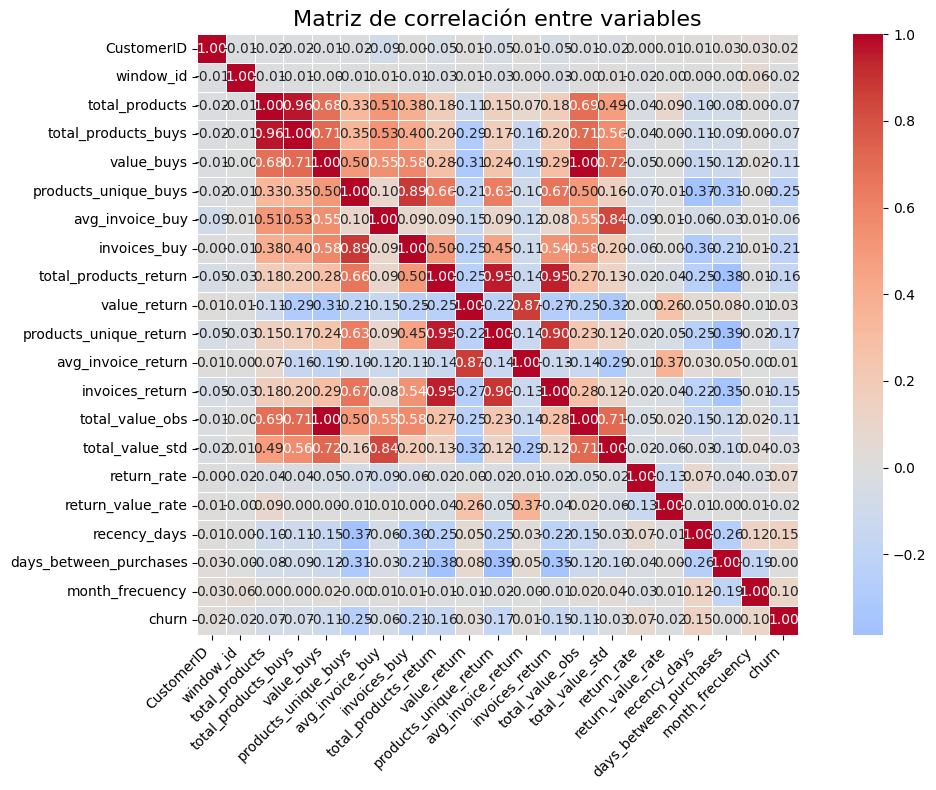

In [15]:
# Si estás usando tu DataFrame final con todas las features + churn
# Filtramos solo las columnas numéricas
df_corr = df_ventanas.select_dtypes(include='number')

# Calculamos la matriz de correlación
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5)

plt.title("Matriz de correlación entre variables", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Seleccionar solo columnas numéricas (incluyendo churn)
df_numericas = df_ventanas.select_dtypes(include='number')

# Asegúrate que 'churn' esté como entero
df_numericas['churn'] = df_numericas['churn'].astype(int)

# Plot
sns.pairplot(df_numericas, hue='churn', corner=True, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot de todas las variables numéricas", y=1.02)
plt.show()

In [ ]:
# Seleccionar columnas numéricas (excluyendo 'ventana_id' si no es feature)
# df_hist = df_ventanas[df_ventanas['ventana_id'] == 1].copy()
df_hist = df_ventanas.copy()
df_hist = df_hist.select_dtypes(include='number').drop(columns=['ventana_id'], errors='ignore')

# Crear subplots
num_cols = df_hist.shape[1]
num_rows = (num_cols + 2) // 3  # 3 columnas por fila

plt.figure(figsize=(15, num_rows * 4))

for i, col in enumerate(df_hist.columns, 1):
    plt.subplot(num_rows, 3, i)
    plt.hist(df_hist[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {col}')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df_ventanas.info()

In [87]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df_ventanas = pd.get_dummies(df_ventanas, columns=['month_frecuency'], prefix='mes', dtype=int)

df_train = df_ventanas[df_ventanas['window_id'] == 1].copy()
df_val   = df_ventanas[df_ventanas['window_id'] == 2].copy()
df_test  = df_ventanas[df_ventanas['window_id'] == 3].copy()

features = df_ventanas.drop(columns=['CustomerID', 'window_id', 'churn'], errors='ignore').select_dtypes(include='number').columns.tolist()
target = 'churn'

X_train, y_train = df_train[features], df_train[target]
X_val, y_val     = df_val[features], df_val[target]

In [88]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

# Entrenar
model.fit(X_train, y_train)

# Evaluar en validación
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("ROC AUC Score:", roc_auc_score(y_val, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      1188
           1       0.56      0.52      0.54       896

    accuracy                           0.62      2084
   macro avg       0.61      0.60      0.61      2084
weighted avg       0.61      0.62      0.61      2084

ROC AUC Score: 0.6831789810305436


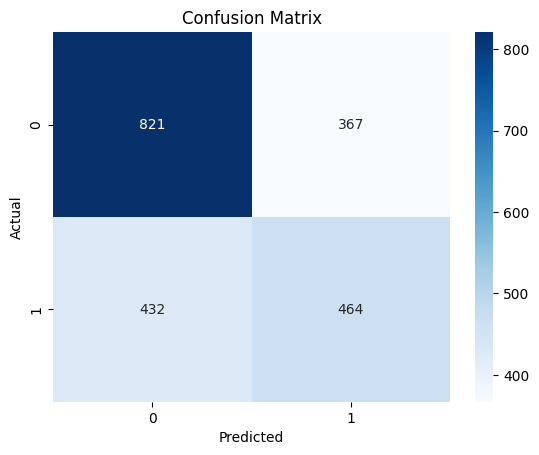

In [89]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [90]:
# Lista de modelos con diferentes parámetros
param_list = [
    {'max_depth': 3, 'learning_rate': 0.1},
    {'max_depth': 5, 'learning_rate': 0.1},
    {'max_depth': 3, 'learning_rate': 0.3},
    {'max_depth': 5, 'learning_rate': 0.3},
]

mejores_params = None
mejor_auc = 0

for params in param_list:
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        **params
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    print(f"Params {params} - AUC: {auc:.4f}")

    if auc > mejor_auc:
        mejor_auc = auc
        mejores_params = params

Params {'max_depth': 3, 'learning_rate': 0.1} - AUC: 0.7228
Params {'max_depth': 5, 'learning_rate': 0.1} - AUC: 0.7045
Params {'max_depth': 3, 'learning_rate': 0.3} - AUC: 0.6924
Params {'max_depth': 5, 'learning_rate': 0.3} - AUC: 0.6892


In [91]:
# Entrenar con mejores parámetros
final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **mejores_params
)
X_trainval = pd.concat([df_train, df_val])[features]
y_trainval = pd.concat([df_train, df_val])[target]

final_model.fit(X_trainval, y_trainval)

# Test
X_test = df_test[features]
y_test = df_test[target]
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("Reporte en Test:")
print(classification_report(y_test, y_pred))
print("ROC AUC Test:", roc_auc_score(y_test, y_proba))

Reporte en Test:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1395
           1       0.45      0.56      0.50       599

    accuracy                           0.66      1994
   macro avg       0.62      0.63      0.62      1994
weighted avg       0.68      0.66      0.67      1994

ROC AUC Test: 0.6989450757235776


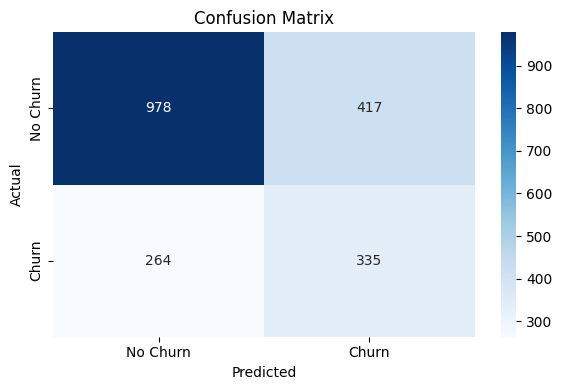

In [92]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [22]:
# XGBOOST CON GRIDSEARCH
df_trainval = (
    df_ventanas
    .loc[df_ventanas['window_id'].between(1, 6)]
    .sort_values(['window_id'])   # ① orden temporal
    .reset_index(drop=True)
)

features = (
    df_trainval
    .drop(columns=['CustomerID', 'window_id', 'churn'], errors='ignore')
    .select_dtypes(include='number')
    .columns
    .tolist()
)

target = 'churn'

X = df_trainval[features]
y = df_trainval['churn']

In [17]:
from collections import Counter
# Calcular scale_pos_weight
# -----------------------------------------
counter = Counter(y)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 1.16


In [18]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, scale_pos_weight, scale_pos_weight * 1.5],
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1.163751987281399, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1.163751987281399, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_po

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [19]:
print("Mejores hiperparámetros:")
print(grid.best_params_)
print("Mejor AUC en validación cruzada:")
print(grid.best_score_)

Mejores hiperparámetros:
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1.7456279809220985, 'subsample': 0.8}
Mejor AUC en validación cruzada:
0.695205250014817


In [20]:
mejores_params = grid.best_params_

final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **mejores_params
)

# Entrenar con train+val (por ejemplo usando ventanas 1–6)
final_model.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [23]:
df_test = df_ventanas[df_ventanas['window_id'] == 7].copy()
X_test = df_test[features]
y_test = df_test[target]

In [24]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]  # Para ROC AUC

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
auc = roc_auc_score(y_test, y_proba)
print("\nROC AUC Score:", auc)


Matriz de Confusión:
[[628 677]
 [119 518]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.48      0.61      1305
           1       0.43      0.81      0.57       637

    accuracy                           0.59      1942
   macro avg       0.64      0.65      0.59      1942
weighted avg       0.71      0.59      0.60      1942


ROC AUC Score: 0.7001190927299301


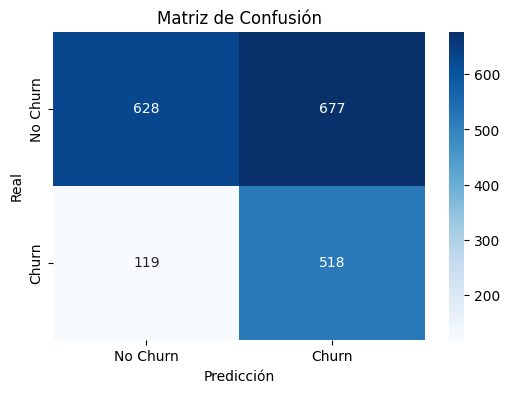

In [26]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [29]:
importances = pd.Series(final_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)

invoices_buy              0.225554
days_between_purchases    0.201799
products_unique_buys      0.168410
total_value_obs           0.065634
value_buys                0.065627
total_products            0.051470
month_frecuency           0.047379
total_products_buys       0.045413
avg_invoice_buy           0.031540
total_value_std           0.028353
dtype: float32

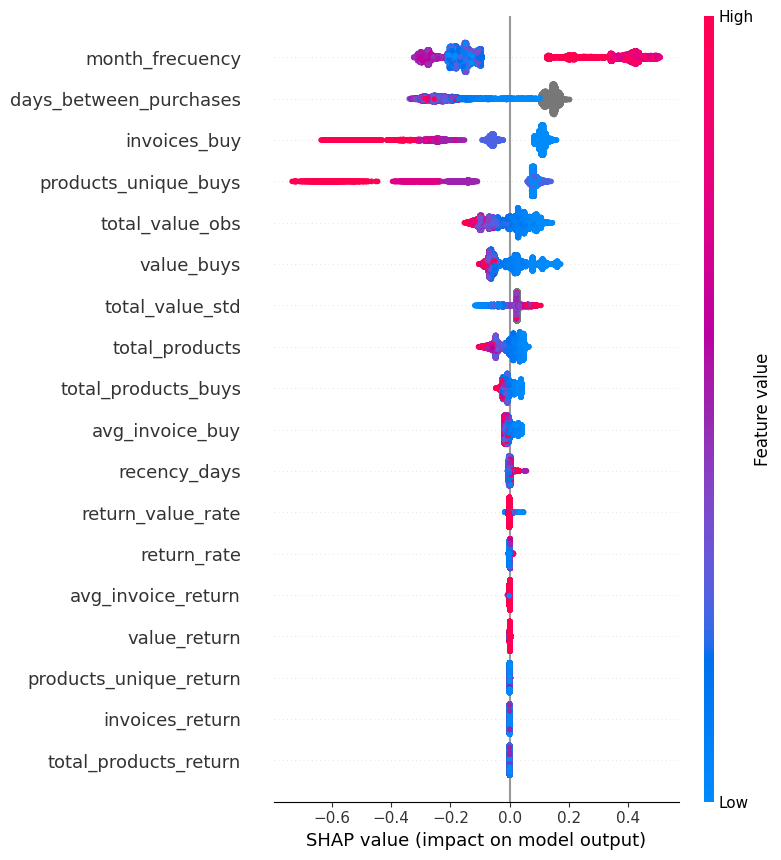

In [32]:
import shap

explainer = shap.Explainer(final_model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)